In [1]:
# See if I'm still not interpolating properly for all combinations

# File Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import stat
import math
import geopandas as gpd
import netCDF4
import datetime
import itertools
import shapely 
from shapely.geometry import LineString, shape
import folium
from colormap import rgb2hex
from folium.plugins import FloatImage
from scipy import interpolate
import alphashape
import descartes
import pyproj
import xarray as xr
from random import sample
import scipy
from sklearn.cluster import KMeans

transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("EPSG:32760"),pyproj.CRS("EPSG:4326")) 

In [3]:
import os
# import rpy2
# os.environ['R_HOME'] = '/lib/R'
# %load_ext rpy2.ipython

# Load the shoreline data

In [4]:
# Load the data using geopandas

base_dir = r"C:\Users\shannonb\Documents\Pacific_coastal_modelling\Work_extracted\Tuvalu_shoreline_change"

proxies = [
    r'TOB',
    r'VL',
    r'WM'
]

atolls = [
    'Nanumea',
    'Nanumaga'
]

locations_dict = {
    'Nanumea':[-5.667723, 176.094928],
    'Nanumaga':[-6.287944, 176.321295]
}

combinations = list(itertools.product(atolls,proxies))

# Define the years the shoreline change datafile is for. This is atoll specific
years_dict = {
    'Nanumea':'1971_2020',
    'Nanumaga':'2003_2020'
}

geopandas_dict = {}

for combination in combinations:
    atoll = combination[0]
    proxy = combination[1]
    year = years_dict[combination[0]]
    geopandas_dict.update({
        (atoll,proxy):gpd.read_file(base_dir+'\Preprocessed_datasets\Shoreline_shapefiles\{}\{}_{}_{}.shp'.format(proxy,atoll,proxy,year))
    })



In [5]:
# converting the geopandas dataframes into a useable pd.dataframe

df_xy_dict = {}

for combination in combinations:
    atoll = combination[0]
    proxy = combination[1]
    year = years_dict[combination[0]]
    
    gdf_test = geopandas_dict[atoll,proxy].copy()

    # Correct some typos
    gdf_test.loc[gdf_test.layer=='Nanumea_WM_2015_','layer'] = 'Nanumea_WM_2015'

    gdf_test['layer'] = gdf_test['layer'].fillna(value=1)
    gdf_test['id'] = gdf_test['id'].fillna(value=1)
    gdf_test.dropna(inplace=True)

    years_list = []
    gdf_right_years_dict = {}

    for layer,group in gdf_test.groupby('layer'):
        if (proxy=='VL')&(atoll!='Nanumaga'):
            year = int(layer.split('_')[1])
        else:
            year = int(layer.split('_')[-1])
        years_list.append(year)

        gdf_right_years_dict.update({
            year:group
        })

    gdf_test = pd.concat(gdf_right_years_dict)
    # gdf_test = gdf_test.rename_axis('year')
    gdf_test.reset_index(drop=False,inplace=True)

    # Convert polygons to linestrings if there are any
    if type(gdf_test.loc[0,'geometry'])==shapely.geometry.Polygon:
        gdf_test['geometry'] = [x.boundary for x in gdf_test.geometry]
        
    # Based on the length of the line segments, calculate the number of segments for this islet
    shape = gdf_test.loc[0,'geometry']
    list_of_line_segments = list(shape.coords)
    total_seg_length = 0
    for seg_1,seg_2 in zip(list_of_line_segments[:-1],list_of_line_segments[1:]):
        total_seg_length+=((seg_1[0]-seg_2[0])**2+(seg_1[1]-seg_2[1])**2)**0.5
    line_segment_length_after_interp = 35
    total_number_of_line_segments = int(np.round(total_seg_length/35))
        
    # Interpolate the linestrings so that they are all of the same length (x)
    x = total_number_of_line_segments #number of points to interpolate
    for i in np.arange(0,len(gdf_test),1):
        gdf_test.loc[i,'geometry'] = \
            shapely.geometry.linestring.LineString(
                [gdf_test.loc[i,'geometry'].interpolate((j/x), normalized=True) for j in range(1, x)]
            )

    dict_of_df_xy = {}

    for idx,row in gdf_test.iterrows():
        linestring = row.geometry
        XY_list = []
        
        if type(linestring)==shapely.geometry.linestring.LineString:
            XY_list = XY_list+[(x,y) for x,y in linestring.coords]
        elif type(linestring)==shapely.geometry.multilinestring.MultiLineString:
            XY_list = XY_list+[(x,y) for x,y in linestring[0].coords]
                
        df_xy = pd.DataFrame(XY_list)
        df_xy.columns = ['lon','lat']
        df_xy['id'] = int(row.id)
        df_xy['year'] = int(row.level_0)
#         print(row.id)
        
        dict_of_df_xy.update({
            idx:df_xy
        })

    df_xy = pd.concat(dict_of_df_xy)

    df_xy = df_xy.reset_index(drop=True)

    df_xy[('lat,lon')] = [transformer.transform(x,y) for x,y in zip(df_xy.lon,df_xy.lat)]
    df_xy['lon'] = [x[1] for x in df_xy[('lat,lon')]]
    df_xy['lat'] = [x[0] for x in df_xy[('lat,lon')]]
    
    gdf_test['level_0'] = gdf_test.level_0.astype(int)
    gdf_test['id'] = gdf_test.id.astype(int)
    gdf_test = gdf_test.rename(columns={'level_0':'year'}).drop('level_1',axis=1)
    
    print(np.unique(df_xy.id))
    print(np.unique(gdf_test.id))
    
    df_xy_dict.update({
        (atoll,proxy):{
            'df_xy':df_xy,
            'gdf_test':gdf_test
        }
    })
    

[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[ 1 11]
[ 1 11]
[1]
[1]
[1]
[1]


## Calculate Islet Area

In [6]:
# # Islet area is already calculated, but it doesn't have a good resolution
# areas_dict = {}

# for key in geopandas_dict.keys():
#     print(key)
#     df_copy = geopandas_dict[key].copy()
#     df_copy['id'] = df_copy['id'].replace([None],1)

#     area_per_combo = {}
    
#     for index,row in df_copy.iterrows():
#         coordinates = []

#         if row.geometry!=None:
#             if type(row.geometry)==shapely.geometry.linestring.LineString:
#                 for index_2,point in enumerate(row.geometry.coords):
#                     if index_2==0:
#                         first_pt = point
#                     coordinates.append(point)

#                 coordinates.append(first_pt)

#                 poly = shapely.geometry.Polygon(coordinates).area/10**4  
#             else:
#                 poly = row.geometry.area/10**4
            
#         else:
#             poly = np.nan

#         area_per_combo.update({
#             (row.id,row.layer.split('-')[-1]):poly
#         })
        
#     areas_dict.update({
#         key:pd.DataFrame.from_dict(area_per_combo,orient='index')
#     })
    

In [7]:
# df_areas = pd.concat(areas_dict)
# df_areas = df_areas.reset_index()
# df_areas['id'],df_areas['islet_proxy_year'] = zip(*df_areas.level_2)
# df_areas['year'] = [x.split('_')[2] if x.split('_')[2].isdigit() else x.split('_')[1] for x in df_areas.islet_proxy_year]
# df_areas = df_areas.drop(['islet_proxy_year','level_2'],axis=1)
# df_areas.columns = ['islet','proxy','area (ha)','id','year']
# # df_areas['islet'] = [x.split('_')[0] for x in df_areas.islet_proxy_year]

# df_areas.replace('Nanumaga','Nanumanga',inplace=True)
# df_areas.replace('Vegetation','VL',inplace=True)
# df_areas.replace('VegetationLine','VL',inplace=True)
# df_areas.replace('VegetationLineV1','VL',inplace=True)
# df_areas.loc[(df_areas.year=='WM'),'year'] = 2013
# df_areas['year'] = df_areas.year.astype(int)

# none_indexes = df_areas[~df_areas.id.isin([1,2,3,4,5,6,'1','2','3','4','5','6'])].index
# df_areas.loc[none_indexes,'id'] = 1
# df_areas['id'] = df_areas.id.astype(int)

# df_areas.to_csv('areas.csv',index=False)


In [8]:
# df_areas = pd.concat(areas_dict)
# df_areas = df_areas.reset_index()
# df_areas['id'],df_areas['islet_proxy_year'] = zip(*df_areas.level_2)
# df_areas['islet'] = [x.split('_')[0] for x in df_areas.islet_proxy_year]
# df_areas['proxy'] = [x.split('_')[1] if not x.split('_')[1].isdigit() else x.split('_')[2] for x in df_areas.islet_proxy_year]
# df_areas['year'] = [x.split('_')[2] if x.split('_')[2].isdigit() else x.split('_')[1] for x in df_areas.islet_proxy_year]
# df_areas.rename(columns={0:'area (ha)'},inplace=True)
# df_areas = df_areas[['id','islet','proxy','year','area (ha)']]
# df_areas.replace('Nanumaga','Nanumanga',inplace=True)
# df_areas.replace('Vegetation','VL',inplace=True)
# df_areas.replace('VegetationLine','VL',inplace=True)
# df_areas.replace('VegetationLineV1','VL',inplace=True)
# df_areas.loc[(df_areas.year=='WM'),'year'] = 2013
# df_areas['year'] = df_areas.year.astype(int)
# none_indexes = df_areas[~df_areas.id.isin([1,2,3,4,5,6,'1','2','3','4','5','6'])].index
# df_areas.loc[none_indexes,'id'] = 1
# df_areas['id'] = df_areas.id.astype(int)

# df_areas.to_csv('areas.csv',index=False)

# Creating Transects

In [9]:

def create_shoreline_df(df_xy):
    # xy = alpha_shape.exterior.coords.xy
    n=2 # length of the shift

    df_shoreline = pd.DataFrame({'x':df_xy.lon[::n],
                                 'x+n':list(df_xy.lon[(n)::n])+[np.nan],
                                 'y':df_xy.lat[::n],
                                 'y+n':list(df_xy.lat[(n)::n])+[np.nan]})

    # Calculate the gradient of the line between the two shoreline points
    df_shoreline['m_shoreline'] = (df_shoreline['y']-df_shoreline['y+n'])/(df_shoreline['x']-df_shoreline['x+n'])
    df_shoreline.dropna(axis=0,inplace=True)
    df_shoreline = df_shoreline[(df_shoreline['x']-df_shoreline['x+n'])!=0]

    # Find the inverse of the gradient (because we are wanting the line that is perpendicular to the shoreline)
    df_shoreline['m_transect'] = -df_shoreline['m_shoreline']**-1

    df_shoreline['x_avg'] = [x/2 for x in (df_shoreline['x']+df_shoreline['x+n'])]
    df_shoreline['y_avg'] = [y/2 for y in (df_shoreline['y']+df_shoreline['y+n'])]

    df_shoreline['c_shoreline'] = df_shoreline['y_avg']-df_shoreline['m_shoreline']*df_shoreline['x_avg']
    df_shoreline['c_transect'] = df_shoreline['y_avg']-df_shoreline['m_transect']*df_shoreline['x_avg']

    # df_shoreline['x_proj'] = df_shoreline['x_avg']+0.01
    # df_shoreline['y_proj'] = df_shoreline['m']*df_shoreline['x_proj']+df_shoreline['c']

    H = 0.001 # length of the line
    delta_y = [abs(H*math.sin(math.atan(m))) for m in df_shoreline['m_transect']]
    delta_x = [abs(H*math.cos(math.atan(m))) for m in df_shoreline['m_transect']]

    # df_shoreline['y_new'] = df_shoreline['y_avg']+delta_y
    # df_shoreline['x_new'] = df_shoreline['x_avg']+delta_x

    df_shoreline['x_new'] = [(x_avg+dx) if y1>y2 else (x_avg-dx) for y1,y2,x_avg,dx in zip(df_shoreline['y'],df_shoreline['y+n'],df_shoreline['x_avg'],delta_x)]
    df_shoreline['y_new'] = [(y_avg+dy) if x1<x2 else (y_avg-dy) for x1,x2,y_avg,dy in zip(df_shoreline['x'],df_shoreline['x+n'],df_shoreline['y_avg'],delta_y)]

    return(df_shoreline)


def calc_shoreline_change(df_shoreline_1,df_shoreline_2,end_year_poly):
    '''
        Function for finding shoreline change between two years
    '''
    ### Now you need to find the distance between the two shorelines using the transects
    shoreline_1_updated_dict = {}

    # loop over each transect
    for idx,row in df_shoreline_1.iterrows():
        
        df_intersection = df_shoreline_2.copy()
        
        df_intersection['x_intersect_location'] = (df_intersection.c_shoreline-row.c_transect)/(row.m_transect-df_intersection.m_shoreline)
        df_intersection['y_intersect_location'] = row['m_transect']*df_intersection['x_intersect_location']+row['c_transect']
        df_intersection['intersect_distance'] = np.sqrt((df_intersection['y_intersect_location']-row['y_avg'])**2+\
        (df_intersection['x_intersect_location']-row['x_avg'])**2)

        # Find which shoreline segments would intersect with the shoreline
        df_intersection = df_intersection[[(x<x_int)&(x_n>x_int)|(x>x_int)&(x_n<x_int)for x,x_int,x_n in zip(df_intersection.x,df_intersection.x_intersect_location,df_intersection['x+n'])]]
        df_intersection = df_intersection[[(y<y_int)&(y_n>y_int)|(y>y_int)&(y_n<y_int) for y,y_int,y_n in zip(df_intersection.y,df_intersection.y_intersect_location,df_intersection['y+n'])]]
        # There may be multiple, so find the closest one (that *should* be the right one)
        
        try:
            df_intersection = df_intersection[(df_intersection['intersect_distance']==np.min(df_intersection['intersect_distance']))]
            intersect_distance = df_intersection.intersect_distance.reset_index(drop=True)[0]
        except:
            intersect_distance = 0
        row['intersect_distance'] = intersect_distance

        shoreline_1_updated_dict.update({
            idx:row
        })

    df_shoreline_1 = pd.DataFrame.from_dict(shoreline_1_updated_dict,orient='index')

    df_shoreline_1['transect_angle'] = \
        np.arctan((df_shoreline_1.y_new-df_shoreline_1.y_avg)/(df_shoreline_1.x_new-df_shoreline_1.x_avg))*180/np.pi

    # Find if there is erosion or accretion
    df_shoreline_1['erosion'] = [shapely.geometry.Point(row.x_avg,row.y_avg).within(end_year_poly) for idx,row in df_shoreline_1.iterrows()]
    
    # If there is erosion, make the value negative
    df_shoreline_1['intersect_distance'] = [dist if eros is False else -dist for dist,eros in zip(df_shoreline_1.intersect_distance,df_shoreline_1.erosion)]
    
    return(df_shoreline_1)


def calc_shoreline_slope_change(df_shoreline_1,df_shoreline_2):
    '''
        Find the rate of change in the shoreline direction
    '''
    
    df_shoreline_1 = pd.concat([df_shoreline_1,df_shoreline_1])
    df_shoreline_2 = pd.concat([df_shoreline_2,df_shoreline_2])

    df_shoreline_1 = df_shoreline_1.reset_index(drop=True)
    df_shoreline_2 = df_shoreline_2.reset_index(drop=True)

    df_shoreline_1_dict = {}

    for (idx_1,row_1),(idx_2,row_2),(idx_3,row_3) in zip(
        df_shoreline_1[2:].iterrows(),
        df_shoreline_1[1:-1].iterrows(),
        df_shoreline_1[:-2].iterrows()):
        
        row_2['avg_slope_change'] = np.mean([
            (180*np.arctan((row_1.m_shoreline-row_2.m_shoreline)/(1+row_1.m_shoreline*row_2.m_shoreline))/np.pi),
            (180*np.arctan((row_2.m_shoreline-row_3.m_shoreline)/(1+row_2.m_shoreline*row_3.m_shoreline))/np.pi)
        ])

        df_shoreline_1_dict.update({
            idx_2:row_2
        })

    # only look at points where there is a significant change
    df_shoreline_1 = pd.DataFrame.from_dict(df_shoreline_1_dict,orient='index')
    
    # Drop the duplicates
    df_shoreline_1 = df_shoreline_1.drop_duplicates()
    df_shoreline_1.reset_index(drop=True,inplace=True)
    
    #### Now also add in the angle (degrees) that the shoreline is facing
    # Quadrant 1
    df_shoreline_1.loc[(df_shoreline_1.x_new>df_shoreline_1.x_avg)&(df_shoreline_1.y_new>df_shoreline_1.y_avg),'shoreline_direction']=\
        [180*math.atan(np.abs(x_new-x_avg)/np.abs(y_new-y_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new>x_avg)&(y_new>y_avg)]

    # Quadrant 2
    df_shoreline_1.loc[(df_shoreline_1.x_new>df_shoreline_1.x_avg)&(df_shoreline_1.y_new<df_shoreline_1.y_avg),'shoreline_direction']=\
        [90+180*math.atan(np.abs(y_new-y_avg)/np.abs(x_new-x_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new>x_avg)&(y_new<y_avg)]

    # Quadrant 3
    df_shoreline_1.loc[(df_shoreline_1.x_new<df_shoreline_1.x_avg)&(df_shoreline_1.y_new<df_shoreline_1.y_avg),'shoreline_direction']=\
        [180+180*math.atan(np.abs(x_new-x_avg)/np.abs(y_new-y_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new<x_avg)&(y_new<y_avg)]

    # Quadrant 4
    df_shoreline_1.loc[(df_shoreline_1.x_new<df_shoreline_1.x_avg)&(df_shoreline_1.y_new>df_shoreline_1.y_avg),'shoreline_direction']=\
        [270+180*math.atan(np.abs(y_new-y_avg)/np.abs(x_new-x_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new<x_avg)&(y_new>y_avg)]

    return(df_shoreline_1)

In [10]:
# For each year, proxy and islet combination, find the shoreline change
shorelines_dict = {}

# Each combination of atoll and proxy combination
for key,item in df_xy_dict.items():
    df_xy = item['df_xy']
    gdf_xy = item['gdf_test']
    
    # Now get all the ids for this atoll
    ids = np.unique(df_xy.id)
    
    for ID in ids:
        df_xy_islet = df_xy[df_xy.id==ID]
        gdf_xy_islet = gdf_xy[gdf_xy.id==ID]
            
        # Get all the years
        years = np.sort(np.unique(df_xy_islet.year))
        years_beginning = years[:-1]
        years_end = years[1:]
        
        # Loop over the years, defining the beginning and the end year
        for year_beginning,year_end in zip(years_beginning,years_end):
            
            df_xy_islet_beginning = df_xy_islet[(df_xy_islet.year==year_beginning)]
            df_xy_islet_end = df_xy_islet[(df_xy_islet.year==year_end)]
            
            end_year_linestring = gdf_xy_islet[(gdf_xy_islet.year==year_end)].reset_index().loc[0,'geometry']
            end_year_poly = shapely.ops.transform(lambda x, y: (y, x),
                      shapely.geometry.Polygon([transformer.transform(x,y) for x,y in end_year_linestring.coords])
                     )
            
            
            df_shoreline_1 = create_shoreline_df(df_xy_islet_beginning).reset_index(drop=True)
            df_shoreline_2 = create_shoreline_df(df_xy_islet_end).reset_index(drop=True)

            df_shoreline_1 = calc_shoreline_change(df_shoreline_1,df_shoreline_2,end_year_poly)

            df_shoreline_1 = calc_shoreline_slope_change(df_shoreline_1,df_shoreline_2)
            
            shorelines_dict.update({
                (key[0],key[1],ID,year_beginning,year_end):{
                    'shoreline_1':df_shoreline_1,
                    'shoreline_2':df_shoreline_2
                }
            })
            print((key[0],key[1],ID,year_beginning,year_end))
            
            

('Nanumea', 'TOB', 1, 1971, 1984)
('Nanumea', 'TOB', 1, 1984, 2003)
('Nanumea', 'TOB', 1, 2003, 2005)
('Nanumea', 'TOB', 1, 2005, 2007)
('Nanumea', 'TOB', 1, 2007, 2009)
('Nanumea', 'TOB', 1, 2009, 2010)
('Nanumea', 'TOB', 1, 2010, 2011)
('Nanumea', 'TOB', 1, 2011, 2012)
('Nanumea', 'TOB', 1, 2012, 2013)
('Nanumea', 'TOB', 1, 2013, 2014)
('Nanumea', 'TOB', 1, 2014, 2015)
('Nanumea', 'TOB', 1, 2015, 2016)
('Nanumea', 'TOB', 1, 2016, 2017)
('Nanumea', 'TOB', 1, 2017, 2018)
('Nanumea', 'TOB', 1, 2018, 2019)
('Nanumea', 'TOB', 1, 2019, 2020)
('Nanumea', 'TOB', 2, 1971, 1984)
('Nanumea', 'TOB', 2, 1984, 2003)
('Nanumea', 'TOB', 2, 2003, 2005)
('Nanumea', 'TOB', 2, 2005, 2007)
('Nanumea', 'TOB', 2, 2007, 2009)
('Nanumea', 'TOB', 2, 2009, 2010)
('Nanumea', 'TOB', 2, 2010, 2011)
('Nanumea', 'TOB', 2, 2011, 2012)
('Nanumea', 'TOB', 2, 2012, 2013)
('Nanumea', 'TOB', 2, 2013, 2014)
('Nanumea', 'TOB', 2, 2014, 2015)
('Nanumea', 'TOB', 2, 2015, 2016)
('Nanumea', 'TOB', 2, 2016, 2017)
('Nanumea', 'T

('Nanumea', 'WM', 4, 2017, 2018)
('Nanumea', 'WM', 4, 2018, 2019)
('Nanumea', 'WM', 4, 2019, 2020)
('Nanumea', 'WM', 5, 1971, 1984)
('Nanumea', 'WM', 5, 1984, 2003)
('Nanumea', 'WM', 5, 2003, 2005)
('Nanumea', 'WM', 5, 2005, 2007)
('Nanumea', 'WM', 5, 2007, 2009)
('Nanumea', 'WM', 5, 2009, 2010)
('Nanumea', 'WM', 5, 2010, 2011)
('Nanumea', 'WM', 5, 2011, 2012)
('Nanumea', 'WM', 5, 2012, 2014)
('Nanumea', 'WM', 5, 2014, 2015)
('Nanumea', 'WM', 5, 2015, 2016)
('Nanumea', 'WM', 5, 2016, 2017)
('Nanumea', 'WM', 5, 2017, 2018)
('Nanumea', 'WM', 5, 2018, 2019)
('Nanumea', 'WM', 5, 2019, 2020)
('Nanumea', 'WM', 6, 1971, 1984)
('Nanumea', 'WM', 6, 1984, 2003)
('Nanumea', 'WM', 6, 2003, 2005)
('Nanumea', 'WM', 6, 2005, 2007)
('Nanumea', 'WM', 6, 2007, 2009)
('Nanumea', 'WM', 6, 2009, 2010)
('Nanumea', 'WM', 6, 2010, 2011)
('Nanumea', 'WM', 6, 2011, 2012)
('Nanumea', 'WM', 6, 2012, 2014)
('Nanumea', 'WM', 6, 2014, 2015)
('Nanumea', 'WM', 6, 2015, 2016)
('Nanumea', 'WM', 6, 2016, 2017)
('Nanumea'

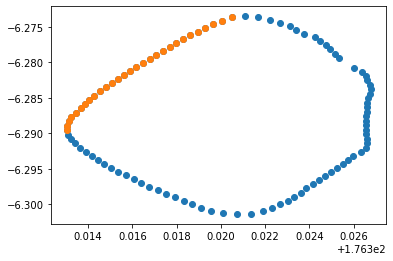

In [11]:
plt.scatter(df_shoreline_1.x,df_shoreline_1.y)
df_test = df_shoreline_1[df_shoreline_1.shoreline_direction>270]
plt.scatter(df_test.x,df_test.y)

In [12]:
shorelines_dict[(key[0],key[1],ID,year_beginning,year_end)]['shoreline_1']

,x,x+n,y,y+n,m_shoreline,m_transect,x_avg,y_avg,c_shoreline,c_transect,x_new,y_new,intersect_distance,transect_angle,erosion,avg_slope_change,shoreline_direction
0,176.326374,176.326534,-6.281287,-6.281900,-3.846220,0.259996,176.326454,-6.281593,671.908739,-52.125683,176.327422,-6.281342,-0.000011,14.573976,True,-13.181856,75.426024
1,176.326534,176.326608,-6.281900,-6.282531,-8.484946,0.117856,176.326571,-6.282216,1489.839273,-27.063322,176.327564,-6.282099,0.000009,6.721632,False,-2.172784,83.278368
2,176.326608,176.326721,-6.282531,-6.283157,-5.541999,0.180440,176.326665,-6.282844,970.919302,-38.099283,176.327649,-6.282667,0.000007,10.228408,False,-0.862632,79.771592
3,176.326721,176.326776,-6.283157,-6.283787,-11.438403,0.087425,176.326749,-6.283472,2010.613001,-21.698801,176.327745,-6.283385,-0.000011,4.996368,True,-6.505029,85.003632
4,176.326776,176.326745,-6.283787,-6.284422,20.581583,-0.048587,176.326761,-6.284105,-3635.367945,2.283106,176.327760,-6.284153,0.000016,-2.781650,False,-7.300853,92.781650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,176.324724,176.324950,-6.277536,-6.278131,-2.637033,0.379214,176.324837,-6.277834,458.696581,-73.142691,176.325772,-6.277479,-0.000093,20.767432,True,-1.995744,69.232568
97,176.324950,176.325149,-6.278131,-6.278734,-3.020467,0.331075,176.325050,-6.278432,526.305558,-64.655184,176.325999,-6.278118,-0.000045,18.318397,True,-0.946883,71.681603
98,176.325149,176.325355,-6.278734,-6.279336,-2.925147,0.341863,176.325252,-6.279035,509.498321,-66.558135,176.326199,-6.278711,-0.000032,18.873666,True,1.680007,71.126334
99,176.325355,176.325590,-6.279336,-6.279927,-2.515648,0.397512,176.325473,-6.279631,437.293144,-76.371111,176.326402,-6.279262,-0.000018,21.678411,True,7.105839,68.321589


In [13]:
df_shoreline_1

,x,x+n,y,y+n,m_shoreline,m_transect,x_avg,y_avg,c_shoreline,c_transect,x_new,y_new,intersect_distance,transect_angle,erosion,avg_slope_change,shoreline_direction
0,176.326374,176.326534,-6.281287,-6.281900,-3.846220,0.259996,176.326454,-6.281593,671.908739,-52.125683,176.327422,-6.281342,-0.000011,14.573976,True,-13.181856,75.426024
1,176.326534,176.326608,-6.281900,-6.282531,-8.484946,0.117856,176.326571,-6.282216,1489.839273,-27.063322,176.327564,-6.282099,0.000009,6.721632,False,-2.172784,83.278368
2,176.326608,176.326721,-6.282531,-6.283157,-5.541999,0.180440,176.326665,-6.282844,970.919302,-38.099283,176.327649,-6.282667,0.000007,10.228408,False,-0.862632,79.771592
3,176.326721,176.326776,-6.283157,-6.283787,-11.438403,0.087425,176.326749,-6.283472,2010.613001,-21.698801,176.327745,-6.283385,-0.000011,4.996368,True,-6.505029,85.003632
4,176.326776,176.326745,-6.283787,-6.284422,20.581583,-0.048587,176.326761,-6.284105,-3635.367945,2.283106,176.327760,-6.284153,0.000016,-2.781650,False,-7.300853,92.781650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,176.324724,176.324950,-6.277536,-6.278131,-2.637033,0.379214,176.324837,-6.277834,458.696581,-73.142691,176.325772,-6.277479,-0.000093,20.767432,True,-1.995744,69.232568
97,176.324950,176.325149,-6.278131,-6.278734,-3.020467,0.331075,176.325050,-6.278432,526.305558,-64.655184,176.325999,-6.278118,-0.000045,18.318397,True,-0.946883,71.681603
98,176.325149,176.325355,-6.278734,-6.279336,-2.925147,0.341863,176.325252,-6.279035,509.498321,-66.558135,176.326199,-6.278711,-0.000032,18.873666,True,1.680007,71.126334
99,176.325355,176.325590,-6.279336,-6.279927,-2.515648,0.397512,176.325473,-6.279631,437.293144,-76.371111,176.326402,-6.279262,-0.000018,21.678411,True,7.105839,68.321589


(array([ 6.,  0.,  1.,  2.,  8., 26., 49.,  5.,  1.,  3.]),
 array([-4.66557206e-04, -3.90725932e-04, -3.14894658e-04, -2.39063385e-04,
        -1.63232111e-04, -8.74008368e-05, -1.15695629e-05,  6.42617109e-05,
         1.40092985e-04,  2.15924259e-04,  2.91755533e-04]),
 <BarContainer object of 10 artists>)

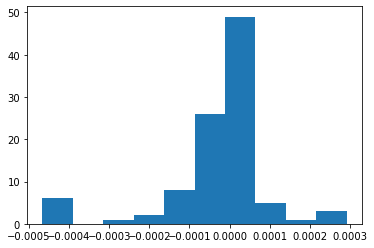

In [14]:
plt.hist(df_shoreline_1.intersect_distance)

In [15]:
# np.max(df_shoreline_1['shoreline_direction'])

In [16]:
# df_xr_atoll['dirr_adjust'] = (df_xr_atoll.dirr+90)
# for index,row in df_shoreline_1.iterrows(): 
#     df_xr_atoll['incidence_angle'] = (df_xr_atoll.dirr_adjust)-row.shoreline_direction
    
#     ##### Have a middle one.... in lots of 60 degrees left, right, straight on
#     # Split the wave incidence into 
#     df_xr_anti_clockwise = df_xr_atoll[(df_xr_atoll['incidence_angle']>0)&(df_xr_atoll['incidence_angle']<=90)|\
#                                        (df_xr_atoll['incidence_angle']+360>0)&(df_xr_atoll['incidence_angle']+360<=90)|\
#                                        (df_xr_atoll['incidence_angle']-360>0)&(df_xr_atoll['incidence_angle']-360<=90)]
#     df_xr_clockwise = df_xr_atoll[(df_xr_atoll['incidence_angle']<0)&(df_xr_atoll['incidence_angle']>=-90)|\
#                                   (df_xr_atoll['incidence_angle']+360<0)&(df_xr_atoll['incidence_angle']+360>=-90)|
#                                   (df_xr_atoll['incidence_angle']-360<0)&(df_xr_atoll['incidence_angle']-360>=-90)]

In [17]:
# df_xr_clockwise

In [18]:
# np.max(df_xr_clockwise.dirr_adjust)

In [19]:
from sklearn.cluster import KMeans


In [20]:
# row

# Testing to see if I have the data that I need for distributions in proxy model

In [21]:
def calc_sheltering(lats,lons,label,row):
    '''zero means no sheltering, 1 means sheltered'''
    sheltered = []
    for lat,lon in zip(lats,lons):

        sheltered_per_islet = []
        for shoreline_1_poly in shoreline_poly_list:

            sheltered_per_islet.append(
                LineString([shapely.geometry.Point(row.x_new,row.y_new),
                   shapely.geometry.Point(lon,lat)]).intersects(shoreline_1_poly)
            )
        
        sheltered.append(any(sheltered_per_islet))
    row[label] = sum(sheltered)>sum([not x for x in sheltered])

    return(row)

In [22]:
var_list = ['x','y','position','shoreline_direction']

In [23]:
df_transect_test = shorelines_dict[('Nanumea', 'TOB', 1, 2012, 2013)]['shoreline_1']
df_transect_test = df_transect_test[df_transect_test.intersect_distance!=np.max(df_transect_test.intersect_distance)]
df_transect_test = df_transect_test[df_transect_test.intersect_distance!=np.min(df_transect_test.intersect_distance)]
df_transect_test = df_transect_test[df_transect_test.intersect_distance!=np.min(df_transect_test.intersect_distance)]

df_transect_test.index.rename('position',inplace=True)

df_transect_test.reset_index(drop=False,inplace=True)

pvalues_per_clust = {}

# fig = plt.figure(figsize=(5,20))

for x in np.arange(2,9,1):
#     ax = plt.subplot2grid((9,1),((x-2),0))
    clusts = KMeans(n_clusters=x)
    clusts = clusts.fit(np.array(df_transect_test[var_list])).predict(np.array(df_transect_test[var_list]))
    df_transect_test[f'clust_{x}'] = clusts
#     ax.scatter(df_transect_test.x,df_transect_test.y,c=clusts)#df_transect_test.intersect_distance)
    pvalues_dict = {}
    for (c1,c2) in list(itertools.combinations(range(x),2)):
        mat1 = df_transect_test.loc[df_transect_test[f'clust_{x}']==c1,'intersect_distance']
        mat2 = df_transect_test.loc[df_transect_test[f'clust_{x}']==c2,'intersect_distance']
        
        pvalues_dict.update({
            (c1,c2):scipy.stats.ttest_ind(mat1,mat2).pvalue
        })
    pvalues_per_clust.update({
        x:pvalues_dict
    })
    
np.mean(pd.DataFrame.from_dict(pvalues_per_clust))<0.05

C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\shannonb\AppData\Local\minif

2     True
3    False
4    False
5    False
6    False
7    False
8    False
dtype: bool

In [24]:
np.mean(pd.DataFrame.from_dict(pvalues_per_clust))==np.min(np.mean(pd.DataFrame.from_dict(pvalues_per_clust)))

C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


2     True
3    False
4    False
5    False
6    False
7    False
8    False
dtype: bool

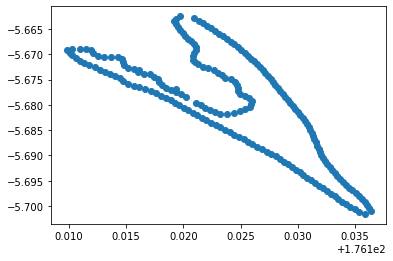

In [25]:
plt.scatter(df_transect_test.x,df_transect_test.y)

In [26]:
df_transect_test[var_list]

,x,y,position,shoreline_direction
0,176.121523,-5.680056,0,52.133034
1,176.121908,-5.680552,1,52.132980
2,176.122294,-5.681048,2,44.163787
3,176.122741,-5.681482,3,38.890477
4,176.123225,-5.681872,4,356.737729
...,...,...,...,...
203,176.119352,-5.676862,206,86.467521
204,176.119388,-5.677433,207,51.556127
205,176.119778,-5.677925,208,49.061072
206,176.120188,-5.678397,209,43.700093


## From df_transects, determine distributions

In [27]:
var_list

['x', 'y', 'position', 'shoreline_direction']

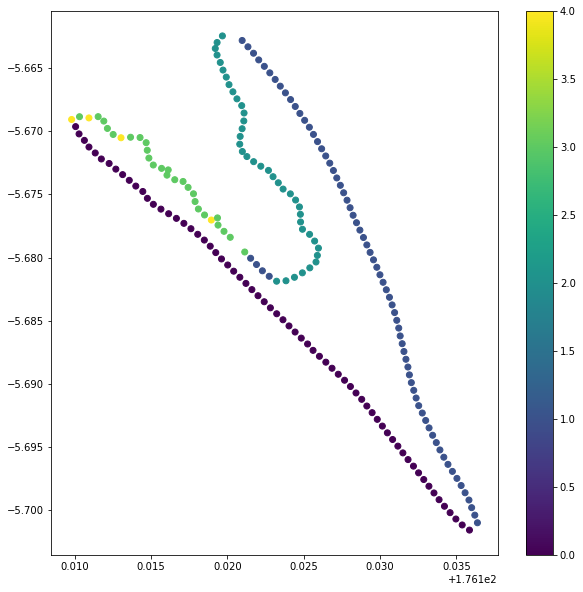

In [28]:
# have a look at some cluster diagrams

fig = plt.figure(figsize=(10,10))

output = plt.scatter(df_transect_test.x,df_transect_test.y,c=df_transect_test['clust_5'])

plt.colorbar(output)

# Find a representative location

In [29]:
cluster_averages = {}

for index,group in df_transect_test.groupby('clust_5'):
    cluster_averages.update({
        index:np.mean(group)
    })

C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [68]:
df_transect_test

,position,x,x+n,y,y+n,m_shoreline,m_transect,x_avg,y_avg,c_shoreline,...,erosion,avg_slope_change,shoreline_direction,clust_2,clust_3,clust_4,clust_5,clust_6,clust_7,clust_8
0,0,176.121523,176.121908,-5.680056,-5.680552,-1.286086,0.777553,176.121715,-5.680304,220.827303,...,False,0.000055,52.133034,0,0,3,1,0,4,1
1,1,176.121908,176.122294,-5.680552,-5.681048,-1.286083,0.777555,176.122101,-5.680800,220.826856,...,False,3.984624,52.132980,0,0,3,1,0,4,1
2,2,176.122294,176.122741,-5.681048,-5.681482,-0.971229,1.029624,176.122518,-5.681265,165.373948,...,False,6.621251,44.163787,0,0,3,1,0,4,1
3,3,176.122741,176.123225,-5.681482,-5.681872,-0.806624,1.239735,176.122983,-5.681677,136.383330,...,False,23.713029,38.890477,0,0,3,1,0,4,1
4,4,176.123225,176.123840,-5.681872,-5.681837,0.056999,-17.544172,176.123533,-5.681855,-15.720717,...,False,32.663730,356.737729,1,2,1,2,5,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,206,176.119352,176.119388,-5.676862,-5.677433,-16.199153,0.061732,176.119370,-5.677148,2847.307500,...,False,52.870385,86.467521,0,0,0,3,3,3,3
204,207,176.119388,176.119778,-5.677433,-5.677925,-1.259703,0.793838,176.119583,-5.677679,216.180733,...,False,18.703225,51.556127,0,0,0,3,3,3,3
205,208,176.119778,176.120188,-5.677925,-5.678397,-1.152848,0.867417,176.119983,-5.678161,197.361391,...,False,3.928017,49.061072,0,0,0,3,3,3,3
206,209,176.120188,176.120639,-5.678397,-5.678829,-0.955624,1.046437,176.120413,-5.678613,162.626259,...,True,-1.536009,43.700093,0,0,0,3,3,3,3


In [30]:
df_cluster_averages = pd.DataFrame(cluster_averages).T

In [31]:
df_cluster_averages

,position,x,x+n,y,y+n,m_shoreline,m_transect,x_avg,y_avg,c_shoreline,...,erosion,avg_slope_change,shoreline_direction,clust_2,clust_3,clust_4,clust_5,clust_6,clust_7,clust_8
0,147.000000,176.123315,176.122926,-5.685218,-5.684733,-1.291456,0.822311,176.123120,-5.684975,221.770766,...,0.462687,0.015471,231.255778,1.0,1.0,2.0,0.0,1.000,1.000000,3.447761
1,74.633803,176.129015,176.129257,-5.681516,-5.682088,-2.884854,0.437288,176.129136,-5.681802,502.429145,...,0.732394,0.672689,67.063393,0.0,0.0,3.0,1.0,0.000,1.521127,4.098592
2,23.500000,176.122518,176.122443,-5.672791,-5.672299,-0.403546,-0.285783,176.122481,-5.672545,65.405197,...,0.300000,0.671075,263.115622,1.0,2.0,1.0,2.0,2.525,2.700000,2.525000
3,196.461538,176.116030,176.116380,-5.673477,-5.673892,-2.047825,2.198679,176.116205,-5.673685,354.983262,...,0.461538,2.234267,49.944885,0.0,0.0,0.0,3.0,3.000,3.000000,3.000000
4,189.250000,176.113175,176.113712,-5.671395,-5.671262,0.268549,-6.479598,176.113443,-5.671329,-52.966585,...,0.500000,22.719776,345.280144,1.0,1.0,2.0,4.0,4.000,5.000000,4.000000


In [34]:
df_transect_test

,position,x,x+n,y,y+n,m_shoreline,m_transect,x_avg,y_avg,c_shoreline,...,erosion,avg_slope_change,shoreline_direction,clust_2,clust_3,clust_4,clust_5,clust_6,clust_7,clust_8
0,0,176.121523,176.121908,-5.680056,-5.680552,-1.286086,0.777553,176.121715,-5.680304,220.827303,...,False,0.000055,52.133034,0,0,3,1,0,4,1
1,1,176.121908,176.122294,-5.680552,-5.681048,-1.286083,0.777555,176.122101,-5.680800,220.826856,...,False,3.984624,52.132980,0,0,3,1,0,4,1
2,2,176.122294,176.122741,-5.681048,-5.681482,-0.971229,1.029624,176.122518,-5.681265,165.373948,...,False,6.621251,44.163787,0,0,3,1,0,4,1
3,3,176.122741,176.123225,-5.681482,-5.681872,-0.806624,1.239735,176.122983,-5.681677,136.383330,...,False,23.713029,38.890477,0,0,3,1,0,4,1
4,4,176.123225,176.123840,-5.681872,-5.681837,0.056999,-17.544172,176.123533,-5.681855,-15.720717,...,False,32.663730,356.737729,1,2,1,2,5,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,206,176.119352,176.119388,-5.676862,-5.677433,-16.199153,0.061732,176.119370,-5.677148,2847.307500,...,False,52.870385,86.467521,0,0,0,3,3,3,3
204,207,176.119388,176.119778,-5.677433,-5.677925,-1.259703,0.793838,176.119583,-5.677679,216.180733,...,False,18.703225,51.556127,0,0,0,3,3,3,3
205,208,176.119778,176.120188,-5.677925,-5.678397,-1.152848,0.867417,176.119983,-5.678161,197.361391,...,False,3.928017,49.061072,0,0,0,3,3,3,3
206,209,176.120188,176.120639,-5.678397,-5.678829,-0.955624,1.046437,176.120413,-5.678613,162.626259,...,True,-1.536009,43.700093,0,0,0,3,3,3,3


# Creating wave data

In [32]:
asdf

NameError: name 'asdf' is not defined

In [ ]:

from processing_waves import averaging_waves,calc_wave_power

nanumanga_dates = list(pd.read_csv('Nanumaga_dates.tsv',sep='\t'))
nanumanga_dates = \
    [pd.to_datetime(x) for x in nanumanga_dates]


nanumea_dates = list(pd.read_csv('Nanumea_dates.tsv',sep='\t'))
nanumea_dates = \
    [pd.to_datetime(x) for x in nanumea_dates]


# averaging_waves('SuperPoint_Nanumaga.nc','Nanumaga')
averaging_waves('SuperPoint_Nanumea.nc','digitised_averages_nanumea')



# Add Sheltering

In [ ]:
atoll = 'Nanumea'
proxy = 'TOB'

shoreline_poly_list = []

ids_nanumanga = [1]
ids = [1,2,3,4,5,6]

for idx in ids:
    df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, 1971, 1984)]['shoreline_1'].copy()
    df_xy_1 = shorelines_dict[(atoll, proxy, idx, 1971, 1984)]['shoreline_1'].copy()
    shoreline_1_poly = shapely.ops.transform(lambda x, y: (y, x),
                              shapely.geometry.Polygon([(y,x) for x,y in zip(df_shoreline_1.x,df_shoreline_1.y)])
                                            )
    
    shoreline_poly_list.append(
        shoreline_1_poly
    )


In [ ]:
shoreline_adjusted_dict = {}

for index,row in df_cluster_averages.iterrows():

    coords = np.arange(0.001,90,1)

    delta_lons = [np.sqrt(np.tan(float(theta)*math.pi/180)**2/(1+np.tan(float(theta)*math.pi/180)**2)) for theta in coords]
    delta_lats = [(1-delta_lon**2)**0.5 for delta_lon in delta_lons]

    lons_q1 = [row.x_avg+delta_lon for delta_lon in delta_lons]
    lats_q1 = [row.y_avg+delta_lat for delta_lat in delta_lats]
    lons_q2 = [row.x_avg+delta_lon for delta_lon in delta_lons]
    lats_q2 = [row.y_avg-delta_lat for delta_lat in delta_lats]
    lons_q3 = [row.x_avg-delta_lon for delta_lon in delta_lons]
    lats_q3 = [row.y_avg-delta_lat for delta_lat in delta_lats]
    lons_q4 = [row.x_avg-delta_lon for delta_lon in delta_lons]
    lats_q4 = [row.y_avg+delta_lat for delta_lat in delta_lats]

    lats_q2.reverse()
    lons_q2.reverse()
    lats_q4.reverse()
    lons_q4.reverse()

    lats = lats_q1+lats_q2+lats_q3+lats_q4
    lons = lons_q1+lons_q2+lons_q3+lons_q4

    df_coords = pd.DataFrame.from_dict({k:{'lat':v1,'lon':v2} for k,v1,v2 in zip(np.arange(0.001,360,1),lats,lons)}).T

    df_coords.index-=row.shoreline_direction

    df_coords_right = df_coords[(df_coords.index>30)&(df_coords.index<=90)|\
                                       (df_coords.index+360>30)&(df_coords.index+360<=90)|\
                                       (df_coords.index-360>30)&(df_coords.index-360<=90)]

    df_coords_mid = df_coords[(df_coords.index>-30)&(df_coords.index<=30)|\
                                       (df_coords.index+360>-30)&(df_coords.index+360<=30)|\
                                       (df_coords.index-360>-30)&(df_coords.index-360<=30)]

    df_coords_left = df_coords[(df_coords.index<-30)&(df_coords.index>=-90)|\
                                  (df_coords.index+360<-30)&(df_coords.index+360>=-90)|
                                  (df_coords.index-360<-30)&(df_coords.index-360>=-90)]

    df_coords.index+=row.shoreline_direction
    df_coords_left.index+=row.shoreline_direction
    df_coords_mid.index+=row.shoreline_direction
    df_coords_right.index+=row.shoreline_direction

    row = calc_sheltering(df_coords_left.lat,df_coords_left.lon,'left',row)
    row = calc_sheltering(df_coords_mid.lat,df_coords_mid.lon,'mid',row)
    row = calc_sheltering(df_coords_right.lat,df_coords_right.lon,'right',row)
    
    asdf
    
    shoreline_adjusted_dict.update({
        index:row
    })   
    
df_transect_test = pd.DataFrame.from_dict(shoreline_adjusted_dict)


In [ ]:
row


In [ ]:
df_transect_test.T.to_csv('cluster_averages.csv',index=False)

# Save csvs

In [60]:
shorelines_1_dict = {}

for k,v in shorelines_dict.items():
    v = v['shoreline_1']
    v['proxy'] = k[1]
    v['atoll'] = k[0]
    v['islet_id'] = k[2]
    v['year2'] = k[-1]
    shorelines_1_dict.update({k:v})


In [61]:
df_shoreline_1_compiled = pd.concat([shorelines_1_dict[x] for x in shorelines_1_dict.keys() if (x[0]=='Nanumea')])


In [63]:
vars_for_BN = ['proxy','atoll','islet_id','year2','intersect_distance','x','y']
df_shoreline_1_compiled = df_shoreline_1_compiled[vars_for_BN]

In [88]:
df_TOB = df_shoreline_1_compiled[df_shoreline_1_compiled.proxy=='TOB'].rename(columns={'intersect_distance':'TOB'})
df_VL = df_shoreline_1_compiled[df_shoreline_1_compiled.proxy=='VL'].rename(columns={'intersect_distance':'VL'})
df_WM = df_shoreline_1_compiled[df_shoreline_1_compiled.proxy=='WM'].rename(columns={'intersect_distance':'WM'})

# [x.set_index(['atoll','islet_id','year2'],inplace=True) for x in [df_TOB,df_VL,df_WM]]

# [x.drop('proxy',axis=1,inplace=True) for x in [df_TOB,df_VL,df_WM]]

# df_dataset_BN = df_TOB.join(df_VL,how='outer').join(df_WM,how='outer')
# df_dataset_BN.reset_index(drop=False,inplace=True)
# df_dataset_BN = df_dataset_BN[df_dataset_BN.islet_id==1]
# df_dataset_BN.drop(['atoll','islet_id'],axis=1,inplace=True)
# df_dataset_BN.to_csv('compiled_nanumea_shoreline.csv',index=False)

# Now assign clusters to each of the vars

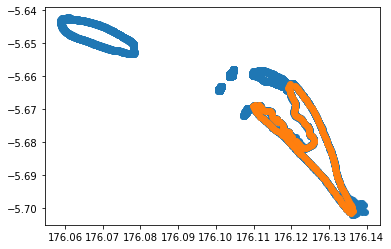

In [114]:

plt.scatter(df_TOB.x,df_TOB.y)

plt.scatter(df_transect_test.x,df_transect_test.y)

In [122]:
TOB_with_clust = []

for index,row in df_TOB.iterrows():
    
     TOB_with_clust.append(
         df_transect_test.loc[((row.x-df_transect_test.x)**2+(row.y-df_transect_test.y)**2).idxmin(),'clust_5']
     )
    
df_TOB['clust'] = TOB_with_clust

#####

VL_with_clust = []

for index,row in df_VL.iterrows():
    
     VL_with_clust.append(
         df_transect_test.loc[((row.x-df_transect_test.x)**2+(row.y-df_transect_test.y)**2).idxmin(),'clust_5']
     )
    
df_VL['clust'] = VL_with_clust

######

WM_with_clust = []

for index,row in df_WM.iterrows():
    
     WM_with_clust.append(
         df_transect_test.loc[((row.x-df_transect_test.x)**2+(row.y-df_transect_test.y)**2).idxmin(),'clust_5']
     )
    
df_WM['clust'] = WM_with_clust

In [158]:
import seaborn as sns
 


0.9999999999999998
1.0000000000000004
1.0000000000000018
0.9999999999999991
1.0000000000000002


C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\shannonb\AppData\Local\miniforge3\envs\pac_model\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please 

(-0.3, 0.3)

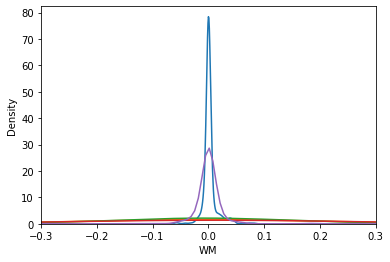

In [175]:
for clust,group in df_WM.groupby('clust'):
    group['WM'] = group.WM/np.sum(group.WM)
    print(np.sum(group.WM))
#     plt.hist(group.WM,alpha=1,bins=np.arange(-0.0015,0.0015,0.0001),histtype='step')
    # plotting density plot for carat using distplot()
    sns.distplot(a=group.WM, hist=False)

    
plt.xlim([-0.3,0.3])

In [178]:
for key,group in df_WM.groupby(['clust','islet_id']):
    print(group)

   proxy    atoll  islet_id  year2        WM           x         y  clust
0     WM  Nanumea         1   1984  0.000001  176.130763 -5.694598      0
1     WM  Nanumea         1   1984  0.000066  176.126683 -5.688644      0
2     WM  Nanumea         1   1984  0.000049  176.121898 -5.683206      0
3     WM  Nanumea         1   1984  0.000081  176.117329 -5.677579      0
4     WM  Nanumea         1   1984 -0.000250  176.112114 -5.672598      0
..   ...      ...       ...    ...       ...         ...       ...    ...
1     WM  Nanumea         1   2020  0.000062  176.125805 -5.687633      0
2     WM  Nanumea         1   2020  0.000017  176.121221 -5.682018      0
3     WM  Nanumea         1   2020 -0.000014  176.116343 -5.676722      0
4     WM  Nanumea         1   2020 -0.000653  176.111331 -5.671575      0
16    WM  Nanumea         1   2020 -0.000056  176.134300 -5.699346      0

[87 rows x 8 columns]
   proxy    atoll  islet_id  year2        WM           x         y  clust
0     WM  Nanum

In [182]:
df_WM.WM

0     0.000001
1     0.000066
2     0.000049
3     0.000081
4    -0.000250
        ...   
30    0.001090
31    0.000473
32    0.000000
33    0.000580
34   -0.000002
Name: WM, Length: 1870, dtype: float64

In [183]:
df_VL.VL

0     1.539225e-05
1     1.279769e-06
2     4.198505e-06
3     3.427669e-05
4     7.705674e-05
          ...     
30   -3.471263e-06
31   -4.163783e-06
32    2.857029e-06
33    7.899808e-06
34   -1.782566e-08
Name: VL, Length: 3326, dtype: float64

In [111]:
df_transect_test.loc[((row.x-df_transect_test.x)**2+(row.y-df_transect_test.y)**2).idxmin(),'clust_4']

2

In [110]:
np.unique(pd.DataFrame.from_dict(TOB_with_clust).T['clust'])

array([2], dtype=object)

In [84]:
df_transect_test.loc[((row.x-df_transect_test.x)**2+(row.y-df_transect_test.y)**2).idxmin(),'clust_5']

0

In [98]:
np.unique(df_TOB.clust)

array([2.])

In [96]:
df_TOB.clust

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
206    0.0
207    0.0
208    0.0
209    0.0
210    0.0
Name: clust, Length: 20045, dtype: float64

In [103]:
row

proxy              TOB
atoll          Nanumea
islet_id             6
year2             2020
TOB           0.000032
x           176.108321
y            -5.670247
clust              NaN
Name: 210, dtype: object

In [99]:
df_transect_test.x

0      176.121523
1      176.121908
2      176.122294
3      176.122741
4      176.123225
          ...    
203    176.119352
204    176.119388
205    176.119778
206    176.120188
207    176.121137
Name: x, Length: 208, dtype: float64

In [66]:
df_VL.reset_index()

,atoll,islet_id,year2,VL,x,y
0,Nanumea,1,1984,1.539225e-05,176.132826,-5.697358
1,Nanumea,1,1984,1.279769e-06,176.130828,-5.694370
2,Nanumea,1,1984,4.198505e-06,176.128994,-5.691296
3,Nanumea,1,1984,3.427669e-05,176.126718,-5.688486
4,Nanumea,1,1984,7.705674e-05,176.124347,-5.685776
...,...,...,...,...,...,...
3321,Nanumea,6,2020,-3.471263e-06,176.100924,-5.663837
3322,Nanumea,6,2020,-4.163783e-06,176.100941,-5.663824
3323,Nanumea,6,2020,2.857029e-06,176.100961,-5.663816
3324,Nanumea,6,2020,7.899808e-06,176.100982,-5.663809


In [67]:
pd.merge(df_TOB.reset_index(),
         df_VL.reset_index(),
         on=['atoll','islet_id','year2','x','y'])

,atoll,islet_id,year2,TOB,x,y,VL


In [57]:
df_TOB.reset_index()

,atoll,islet_id,year2,TOB
0,Nanumea,1,1984,0.000467
1,Nanumea,1,1984,0.000384
2,Nanumea,1,1984,0.000144
3,Nanumea,1,1984,0.000099
4,Nanumea,1,1984,0.000070
...,...,...,...,...
20040,Nanumea,6,2020,0.000001
20041,Nanumea,6,2020,0.000007
20042,Nanumea,6,2020,0.000051
20043,Nanumea,6,2020,0.000042


In [58]:
df_VL.reset_index()

,atoll,islet_id,year2,VL
0,Nanumea,1,1984,1.539225e-05
1,Nanumea,1,1984,1.279769e-06
2,Nanumea,1,1984,4.198505e-06
3,Nanumea,1,1984,3.427669e-05
4,Nanumea,1,1984,7.705674e-05
...,...,...,...,...
3321,Nanumea,6,2020,-3.471263e-06
3322,Nanumea,6,2020,-4.163783e-06
3323,Nanumea,6,2020,2.857029e-06
3324,Nanumea,6,2020,7.899808e-06


In [55]:
df_VL

VL
atoll   islet_id year2              
Nanumea 1        1984   1.539225e-05
                 1984   1.279769e-06
                 1984   4.198505e-06
                 1984   3.427669e-05
                 1984   7.705674e-05
...                              ...
        6        2020  -3.471263e-06
                 2020  -4.163783e-06
                 2020   2.857029e-06
                 2020   7.899808e-06
                 2020  -1.782566e-08

[3326 rows x 1 columns]

In [42]:
df_VL

VL
atoll   islet_id year2              
Nanumea 1        1984   1.539225e-05
                 1984   1.279769e-06
                 1984   4.198505e-06
                 1984   3.427669e-05
                 1984   7.705674e-05
...                              ...
        6        2020  -3.471263e-06
                 2020  -4.163783e-06
                 2020   2.857029e-06
                 2020   7.899808e-06
                 2020  -1.782566e-08

[3326 rows x 1 columns]

In [ ]:
# shoreline_adjusted_dict = {}

# for index,row in df_transect_test.iterrows():

#     coords = np.arange(0.001,90,1)

#     delta_lons = [np.sqrt(np.tan(float(theta)*math.pi/180)**2/(1+np.tan(float(theta)*math.pi/180)**2)) for theta in coords]
#     delta_lats = [(1-delta_lon**2)**0.5 for delta_lon in delta_lons]

#     lons_q1 = [row.x_avg+delta_lon for delta_lon in delta_lons]
#     lats_q1 = [row.y_avg+delta_lat for delta_lat in delta_lats]
#     lons_q2 = [row.x_avg+delta_lon for delta_lon in delta_lons]
#     lats_q2 = [row.y_avg-delta_lat for delta_lat in delta_lats]
#     lons_q3 = [row.x_avg-delta_lon for delta_lon in delta_lons]
#     lats_q3 = [row.y_avg-delta_lat for delta_lat in delta_lats]
#     lons_q4 = [row.x_avg-delta_lon for delta_lon in delta_lons]
#     lats_q4 = [row.y_avg+delta_lat for delta_lat in delta_lats]

#     lats_q2.reverse()
#     lons_q2.reverse()
#     lats_q4.reverse()
#     lons_q4.reverse()

#     lats = lats_q1+lats_q2+lats_q3+lats_q4
#     lons = lons_q1+lons_q2+lons_q3+lons_q4

#     df_coords = pd.DataFrame.from_dict({k:{'lat':v1,'lon':v2} for k,v1,v2 in zip(np.arange(0.001,360,1),lats,lons)}).T

#     df_coords.index-=row.shoreline_direction

#     df_coords_right = df_coords[(df_coords.index>30)&(df_coords.index<=90)|\
#                                        (df_coords.index+360>30)&(df_coords.index+360<=90)|\
#                                        (df_coords.index-360>30)&(df_coords.index-360<=90)]

#     df_coords_mid = df_coords[(df_coords.index>-30)&(df_coords.index<=30)|\
#                                        (df_coords.index+360>-30)&(df_coords.index+360<=30)|\
#                                        (df_coords.index-360>-30)&(df_coords.index-360<=30)]

#     df_coords_left = df_coords[(df_coords.index<-30)&(df_coords.index>=-90)|\
#                                   (df_coords.index+360<-30)&(df_coords.index+360>=-90)|
#                                   (df_coords.index-360<-30)&(df_coords.index-360>=-90)]

#     df_coords.index+=row.shoreline_direction
#     df_coords_left.index+=row.shoreline_direction
#     df_coords_mid.index+=row.shoreline_direction
#     df_coords_right.index+=row.shoreline_direction

#     row = calc_sheltering(df_coords_left.lat,df_coords_left.lon,'left',row)
#     row = calc_sheltering(df_coords_mid.lat,df_coords_mid.lon,'mid',row)
#     row = calc_sheltering(df_coords_right.lat,df_coords_right.lon,'right',row)
    
#     shoreline_adjusted_dict.update({
#         index:row
#     })   
    
# df_transect_test = pd.DataFrame.from_dict(shoreline_adjusted_dict)


In [ ]:
# df_transect_test = df_transect_test.T
# df_transect_test

In [ ]:
fig = plt.figure(figsize=(14,10))

var_list = ['x','y','position','shoreline_direction']

clusts = KMeans(n_clusters=2,
                algorithm='elkan'
               ).fit(np.array(df_transect_test[var_list])).predict(np.array(df_transect_test[var_list]))

#['r' if x==False else 'b' for x in df_transect_test.erosion]

output = plt.scatter(df_transect_test.x,df_transect_test.y,c=clusts)#df_transect_test.intersect_distance)

plt.colorbar(output)

In [ ]:
import scipy

In [ ]:
clusts

In [ ]:
df_transect_test[f'clust_{x}']==c1

In [ ]:
df_transect_test

In [ ]:
list(range(x))

In [ ]:
np.arange(1,x+1,1)

In [ ]:

    print(c1)


In [ ]:
asdf

In [ ]:
range(2)

In [ ]:
np.min(df_transect_test.intersect_distance)

In [ ]:
df_transect_test


# Plotting the Result

In [ ]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot2grid((1,1),(0,0))

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='k') for x,x_n,y,y_n in zip(
    df_shoreline_1['x'],
    df_shoreline_1['x+n'],
    df_shoreline_1['y'],
    df_shoreline_1['y+n']
)]

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='b') for x,x_n,y,y_n in zip(
    df_shoreline_2['x'],
    df_shoreline_2['x+n'],
    df_shoreline_2['y'],
    df_shoreline_2['y+n']
)]

df_shoreline_erosion = df_shoreline_1[df_shoreline_1.erosion==True]
ax.scatter(df_shoreline_erosion['x_avg'],df_shoreline_erosion['y_avg'],s=[-x*1000000 for x in df_shoreline_erosion['intersect_distance']],
            alpha=1,c='c',zorder=-1000)

df_shoreline_acretion = df_shoreline_1[df_shoreline_1.erosion==False]
ax.scatter(df_shoreline_acretion['x_avg'],df_shoreline_acretion['y_avg'],s=1000000*df_shoreline_acretion['intersect_distance'],
            alpha=1,c='r',zorder=-1000)

[ax.plot([x_avg,x_proj],[y_avg,y_proj],alpha=0.5,c='r') for x_avg,x_proj,y_avg,y_proj in zip(
    df_shoreline_1['x_avg'],
    df_shoreline_1['x_new'],
    df_shoreline_1['y_avg'],
    df_shoreline_1['y_new']
)]

# ax.set_xlim(177.5,177.75)
# ax.set_ylim(-6.305,-6.27)
ax.set_aspect('equal', adjustable='box')

ax.add_patch(descartes.PolygonPatch(end_year_poly,alpha=0.2))

# plt.plot(x_test,y_test,c='b')

plt.show()

In [ ]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot2grid((1,1),(0,0))

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='k') for x,x_n,y,y_n in zip(
    df_shoreline_1['x'],
    df_shoreline_1['x+n'],
    df_shoreline_1['y'],
    df_shoreline_1['y+n']
)]

df_shoreline_1_concave = df_shoreline_1[df_shoreline_1.avg_slope_change<0]
df_shoreline_1_concave['avg_slope_change'] = np.abs(df_shoreline_1_concave.avg_slope_change)
df_shoreline_1_convex = df_shoreline_1[df_shoreline_1.avg_slope_change>0]

ax.scatter(df_shoreline_1_concave['x_avg'],df_shoreline_1_concave['y_avg'],s=1*df_shoreline_1_concave['avg_slope_change'],
            alpha=1,c='c',zorder=-1000)
ax.scatter(df_shoreline_1_convex['x_avg'],df_shoreline_1_convex['y_avg'],s=1*df_shoreline_1_convex['avg_slope_change'],
            alpha=1,c='r',zorder=-1000)

[ax.plot([x_avg,x_proj],[y_avg,y_proj],alpha=0.5,c='r') for x_avg,x_proj,y_avg,y_proj in zip(
    df_shoreline_1['x_avg'],
    df_shoreline_1['x_new'],
    df_shoreline_1['y_avg'],
    df_shoreline_1['y_new']
)]

# ax.set_xlim(177.5,177.75)
# ax.set_ylim(-6.305,-6.27)
ax.set_aspect('equal', adjustable='box')

# ax.add_patch(descartes.PolygonPatch(alpha_shape,alpha=0.2))

# plt.plot(x_test,y_test,c='b')

plt.show()

# Determine if you are in the shoreline and the lagoon

In [ ]:
# atoll = 'Nanumea'
# proxy = 'TOB'

# shoreline_poly_list = []

# ids = id_dict[(atoll,proxy)]

# for idx in ids:
#     df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, 1971, 1984)]['shoreline_1'].copy()
#     df_xy_1 = shorelines_dict[(atoll, proxy, idx, 1971, 1984)]['shoreline_1'].copy()
#     shoreline_1_poly = shapely.ops.transform(lambda x, y: (y, x),
#                               shapely.geometry.Polygon([(y,x) for x,y in zip(df_shoreline_1.x,df_shoreline_1.y)])
#                                             )
    
#     shoreline_poly_list.append(
#         shoreline_1_poly
#     )


In [ ]:
# def calc_sheltering(lats,lons,label,row):
#     sheltered = []
#     for lat,lon in zip(lats,lons):

#         sheltered_per_islet = []
#         for shoreline_1_poly in shoreline_poly_list:

#             sheltered_per_islet.append(
#                 LineString([shapely.geometry.Point(row.x_new,row.y_new),
#                    shapely.geometry.Point(lon,lat)]).intersects(shoreline_1_poly)
#             )
#         sheltered.append(any(sheltered_per_islet))
#     row[label] = sum(sheltered)>sum([not x for x in sheltered])

#     return(row)

# delta_lons = [np.sqrt(1/(1+np.tan(theta)**2)) for theta in np.arange(0,360,15)*math.pi/180]
# delta_lats = [np.sqrt(np.tan(theta)**2/(1+np.tan(theta)**2)) for theta in np.arange(0,360,15)*math.pi/180]

# combinations = []
# for key in list(shorelines_dict.keys()):
#     combinations.append((key[0],key[1],key[3],key[4]))
    
# combinations = [t for t in (set(combinations))]

# for key in combinations:
#     print(key)
#     atoll = key[0]
#     proxy = key[1]
#     beginning_year = key[2]
#     end_year = key[3]

#     shoreline_poly_list = []

#     ids = []
#     for n in np.arange(0,20,1):
#         try:
#             shorelines_dict[(atoll,proxy,n,beginning_year,end_year)]
#             ids.append(n)
#         except:
#             continue

#     for idx in ids:
#         df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()
#         df_xy_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()
#         shoreline_1_poly = shapely.ops.transform(lambda x, y: (y, x),
#                                   shapely.geometry.Polygon([(y,x) for x,y in zip(df_shoreline_1.x,df_shoreline_1.y)])
#                                                 )

#         shoreline_poly_list.append(
#             shoreline_1_poly
#         )

#     i=0
#     for idx in ids:
#         df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()

#         shoreline_1_dict = {}

#         for index,row in df_shoreline_1.iterrows():

#             coords = np.arange(0.001,90,1)

#             delta_lons = [np.sqrt(np.tan(float(theta)*math.pi/180)**2/(1+np.tan(float(theta)*math.pi/180)**2)) for theta in coords]
#             delta_lats = [(1-delta_lon**2)**0.5 for delta_lon in delta_lons]

#             lons_q1 = [row.x_avg+delta_lon for delta_lon in delta_lons]
#             lats_q1 = [row.y_avg+delta_lat for delta_lat in delta_lats]
#             lons_q2 = [row.x_avg+delta_lon for delta_lon in delta_lons]
#             lats_q2 = [row.y_avg-delta_lat for delta_lat in delta_lats]
#             lons_q3 = [row.x_avg-delta_lon for delta_lon in delta_lons]
#             lats_q3 = [row.y_avg-delta_lat for delta_lat in delta_lats]
#             lons_q4 = [row.x_avg-delta_lon for delta_lon in delta_lons]
#             lats_q4 = [row.y_avg+delta_lat for delta_lat in delta_lats]

#             lats_q2.reverse()
#             lons_q2.reverse()
#             lats_q4.reverse()
#             lons_q4.reverse()

#             lats = lats_q1+lats_q2+lats_q3+lats_q4
#             lons = lons_q1+lons_q2+lons_q3+lons_q4

#             df_coords = pd.DataFrame.from_dict({k:{'lat':v1,'lon':v2} for k,v1,v2 in zip(np.arange(0.001,360,1),lats,lons)}).T

#             df_coords.index-=row.shoreline_direction

#             df_coords_right = df_coords[(df_coords.index>30)&(df_coords.index<=90)|\
#                                                (df_coords.index+360>30)&(df_coords.index+360<=90)|\
#                                                (df_coords.index-360>30)&(df_coords.index-360<=90)]

#             df_coords_mid = df_coords[(df_coords.index>-30)&(df_coords.index<=30)|\
#                                                (df_coords.index+360>-30)&(df_coords.index+360<=30)|\
#                                                (df_coords.index-360>-30)&(df_coords.index-360<=30)]

#             df_coords_left = df_coords[(df_coords.index<-30)&(df_coords.index>=-90)|\
#                                           (df_coords.index+360<-30)&(df_coords.index+360>=-90)|
#                                           (df_coords.index-360<-30)&(df_coords.index-360>=-90)]

#             df_coords.index+=row.shoreline_direction
#             df_coords_left.index+=row.shoreline_direction
#             df_coords_mid.index+=row.shoreline_direction
#             df_coords_right.index+=row.shoreline_direction

#             row = calc_sheltering(df_coords_left.lat,df_coords_left.lon,'left',row)
#             row = calc_sheltering(df_coords_mid.lat,df_coords_mid.lon,'mid',row)
#             row = calc_sheltering(df_coords_right.lat,df_coords_right.lon,'right',row)
            
# #             df_xr_atoll['incidence_angle'] = (df_xr_atoll.dirr_adjust)-row.shoreline_direction

# #             ##### Have a middle one.... in lots of 60 degrees left, right, straight on
# #             # Split the wave incidence into 
# #             df_xr_right = df_xr_atoll[(df_xr_atoll['incidence_angle']>30)&(df_xr_atoll['incidence_angle']<=90)|\
# #                                                (df_xr_atoll['incidence_angle']+360>30)&(df_xr_atoll['incidence_angle']+360<=90)|\
# #                                                (df_xr_atoll['incidence_angle']-360>30)&(df_xr_atoll['incidence_angle']-360<=90)]
            
# #             df_xr_mid = df_xr_atoll[(df_xr_atoll['incidence_angle']>-30)&(df_xr_atoll['incidence_angle']<=30)|\
# #                                                (df_xr_atoll['incidence_angle']+360>-30)&(df_xr_atoll['incidence_angle']+360<=30)|\
# #                                                (df_xr_atoll['incidence_angle']-360>-30)&(df_xr_atoll['incidence_angle']-360<=30)]
            
# #             df_xr_left = df_xr_atoll[(df_xr_atoll['incidence_angle']<-30)&(df_xr_atoll['incidence_angle']>=-90)|\
# #                                           (df_xr_atoll['incidence_angle']+360<-30)&(df_xr_atoll['incidence_angle']+360>=-90)|
# #                                           (df_xr_atoll['incidence_angle']-360<-30)&(df_xr_atoll['incidence_angle']-360>=-90)]

#             shoreline_1_dict.update({
#                 index:row
#             })

#         df_shoreline_1 = pd.DataFrame.from_dict(shoreline_1_dict,orient='index')

#         shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)].update({
#             'shoreline_1':df_shoreline_1
#         })            
            

In [ ]:
shorelines_dict.keys()

In [ ]:
# df_shoreline_1 = pd.DataFrame.from_dict(shoreline_1_dict,orient='index')

In [ ]:
# df_xr_atoll

In [ ]:
# for idx in ids:
#     df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1']
    
#     plt.scatter(df_shoreline_1.x,df_shoreline_1.y)
    
    

In [ ]:
# coord_adjust = [180-coord if (coord>90)&(coord<180) else coord for coord in coords]
# coord_adjust = [180+coord if (coord>180)&(coord<270) else coord for coord in coords]
# coord_adjust = [360-coord if (coord>270)&(coord<360) else coord for coord in coords]

    
# delta_lons = [-delta_lon if (coord>180) else delta_lon for delta_lon,coord in zip(delta_lons,coords)]
# delta_lats = [-delta_lat if (coord>90)&(coord>270) else delta_lat for delta_lat,coord in zip(delta_lats,coords)]

In [ ]:
# coords = np.arange(0,360,1)
# angle = 180
# coords = coords[((coords>(angle-90))&(coords<(angle+90)))|\
#        (((coords+360)>(angle-90))&((coords+360)<(angle+90)))|\
#        (((coords)>(angle+360-90))&((coords)<(angle+360+90)))]
# coords


# Look at the correlation between these variables and the change in shoreline

In [ ]:
df_combined_shoreline_change = pd.concat({keys:dicts['shoreline_1'] for keys,dicts in shorelines_dict.items()})
df_combined_shoreline_change = \
    df_combined_shoreline_change.reset_index(drop=False).rename(columns={
        'level_0':'atoll',
        'level_1':'proxy',
        'level_2':'islet_id',
        'level_3':'beginning_year',
        'level_4':'end_year'
    }).drop('level_5',axis=1)

In [ ]:
# Round the shoreline direction to the nearest 45 degrees
df_combined_shoreline_change['shoreline_direction'] = (df_combined_shoreline_change.shoreline_direction/45).round()*45
df_combined_shoreline_change['avg_slope_change'] = (df_combined_shoreline_change.avg_slope_change/45).round()*45


In [ ]:

def create_boxplot(var,ax):
    x=0
    xticks_list = []
    for key,group in df_combined_shoreline_change.groupby(var):
        ax.violinplot(dataset=group.intersect_distance,positions=[x])
        x+=1
        xticks_list.append(key)

#     ax.set_xticklabels(xticks_list)
    ax.set(xlim=(-1,x),xticks=np.arange(0,x,1))
    ax.set_xticklabels(xticks_list)
    ax.set_ylabel('Shoreline change')
    ax.set_title('Variable: {}'.format(var))
    
    return(ax)

fig = plt.figure(figsize=(15,25))

ax1 = plt.subplot2grid((5,2),(0,0))
ax2 = plt.subplot2grid((5,2),(0,1))
ax3 = plt.subplot2grid((5,2),(1,0))
ax4 = plt.subplot2grid((5,2),(1,1))
ax5 = plt.subplot2grid((5,2),(2,0))
ax6 = plt.subplot2grid((5,2),(2,1))
ax7 = plt.subplot2grid((5,2),(3,0))
ax8 = plt.subplot2grid((5,2),(3,1))
ax9 = plt.subplot2grid((5,2),(4,0))
ax10 = plt.subplot2grid((5,2),(4,1))

ax1 = create_boxplot('proxy',ax1)
ax2 = create_boxplot('atoll',ax2)
ax3 = create_boxplot('islet_id',ax3)
ax4 = create_boxplot('shoreline_direction',ax4)
ax5 = create_boxplot('left',ax5)
ax6 = create_boxplot('mid',ax6)
ax7 = create_boxplot('right',ax7)
ax9 = create_boxplot('avg_slope_change',ax9)



In [ ]:
key_vars = ['proxy','atoll','islet_id','shoreline_direction','left','mid','right','avg_slope_change','intersect_distance']

corr = df_combined_shoreline_change[key_vars].corr()

In [ ]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.imshow(corr)

In [ ]:
corr

In [ ]:
df_combined_shoreline_change

In [ ]:
plt.hist(df_combined_shoreline_change.intersect_distance)

In [ ]:
%%R -i df_combined_shoreline_change -o intersect_distance_summary

intersect_distance_summary = summary(df_combined_shoreline_change$intersect_distance)
intersect_distance_summary


In [ ]:
intersect_distance_summary

In [ ]:
q1 = intersect_distance_summary[1]
q3 = intersect_distance_summary[3]

In [ ]:
df_combined_shoreline_change_extremes = df_combined_shoreline_change[(df_combined_shoreline_change.intersect_distance<-0.001)|(df_combined_shoreline_change.intersect_distance>0.001)]

In [ ]:
plt.hist(df_combined_shoreline_change_extremes.intersect_distance)

In [ ]:
print(df_combined_shoreline_change_extremes[key_vars].corr().intersect_distance)

In [ ]:
key_vars = ['proxy','shoreline_direction','left','mid','right','avg_slope_change','intersect_distance']
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    corr_dict.update({
        key:group[key_vars].corr().intersect_distance.to_dict()
    })

In [ ]:
pd.DataFrame.from_dict(corr_dict,orient='index')

# Looking at the change in shoreline on a per year basis

In [ ]:
df_combined_shoreline_change_extremes.loc[:,'shoreline_direction_scaled'] = \
    [(x+180)/(360) for x in list(df_combined_shoreline_change_extremes.shoreline_direction)]
df_combined_shoreline_change_extremes['intersect_distance_per_year'] = \
    [x.intersect_distance/(x.end_year-x.beginning_year) for idx,x in df_combined_shoreline_change_extremes.iterrows()]

fig1 = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((3,3),(0,0))
ax2 = plt.subplot2grid((3,3),(0,1))
ax3 = plt.subplot2grid((3,3),(0,2))
ax4 = plt.subplot2grid((3,3),(1,0))
ax5 = plt.subplot2grid((3,3),(1,1))
ax6 = plt.subplot2grid((3,3),(1,2))
ax7 = plt.subplot2grid((3,3),(2,0))
ax8 = plt.subplot2grid((3,3),(2,1))
ax9 = plt.subplot2grid((3,3),(2,2))

for ax,(key,group) in zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9],
                          df_combined_shoreline_change_extremes.groupby(['atoll','islet_id'])
                         ):
    ax.scatter(group.avg_slope_change,group.intersect_distance_per_year,c=group.shoreline_direction_scaled,alpha=0.5)

## How well can a linear model explain the variance

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    print('\033[1m'+str(key)+'\033[0m')
    model = ols(
        "intersect_distance ~ proxy + shoreline_direction + left + mid + right + avg_slope_change",
        data=group).fit()
    print(model.params)
    print(model.summary())
    print('')

In [ ]:
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    print('\033[1m'+str(key)+'\033[0m')
    group.intersect_distance_per_year = -group.intersect_distance_per_year
    model = ols(
        "intersect_distance_per_year ~ proxy + shoreline_direction + left + mid + right + avg_slope_change",
        data=group).fit()
    print(model.params)
    print(model.summary())
    print('')

## Adding Waves Features

In [ ]:
# for index,row in df_combined_shoreline_change.iterrows():
#     waves_per_atoll_year_dict[(row.atoll,row.proxy,beginning_year,end_year)]

In [ ]:
# waves_per_atoll_year_dict[('Nanumea', 'TOB', 1971, 1984)]

In [ ]:
combined_wave_shoreline_stats_dict = {}

# Loop over each row and add wave stats
for index,row in df_combined_shoreline_change.iterrows():
    # For this atoll-proxy-year combination, get the corresponding wave stats dict
    try:
        df_wave_features = pd.concat({key:pd.DataFrame.from_dict(item,orient='index')
         for key,item in waves_per_atoll_year_dict[(row.atoll,row.proxy,row.beginning_year,row.end_year)].items()})
    except:
        print((row.atoll,row.proxy,row.beginning_year,row.end_year))
        continue
        
    # Format the wave stats so that they can be added to the row
    df_wave_features = df_wave_features.reset_index().rename(columns={'level_0':'freq1','level_1':'freq2','level_2':'dirr'})
    df_wave_features = df_wave_features.melt(['freq1','freq2','dirr']).rename(columns={'variable':'stat'})
    df_wave_features.index = \
        [(freq1,freq2,dirr,stat) for freq1,freq2,dirr,stat in zip(
            df_wave_features.freq1,df_wave_features.freq2,df_wave_features.dirr,df_wave_features.stat
        )]
    # Combine the wave stats into the row
    df_wave_features = df_wave_features['value'].T
    row = pd.concat([row,df_wave_features])
    
    # Add to a dictionary
    combined_wave_shoreline_stats_dict.update({
        index:row
    })
    
# get the wave feature list 
wave_features_list = list(df_wave_features.index)

# Combine into a single dataframe
df_combined_wave_shoreline_change = pd.DataFrame.from_dict(combined_wave_shoreline_stats_dict,orient='index')

In [ ]:
df_combined_wave_shoreline_change

## Correlations between shoreline change and previous year

In [ ]:
key_vars = ['proxy','atoll','islet_id','shoreline_direction','left','mid','right','avg_slope_change','intersect_distance']
key_vars = wave_features_list+key_vars

corr = df_combined_wave_shoreline_change[key_vars].corr()

In [ ]:
corr['intersect_distance']

In [ ]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.imshow(corr)

# Beach Sheltering

In [ ]:
key_vars = ['x','y','x_avg','y_avg','m_transect','c_transect','proxy','atoll','islet_id','shoreline_direction','left','mid','right','avg_slope_change','intersect_distance']
key_vars = wave_features_list+key_vars

df_test = df_combined_wave_shoreline_change[key_vars]

In [ ]:
df_test

In [ ]:
# For each direction, get the column names for each quadrant
left_features = [x for x in list(df_test) if 'left' in x]
mid_features = [x for x in list(df_test) if 'mid' in x]
right_features = [x for x in list(df_test) if 'right' in x]

left_features.remove('left')
mid_features.remove('mid')
right_features.remove('right')


In [ ]:
# This isn't going to work anymore

In [ ]:
df_left = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.left_features)] for i in left_features
})

df_mid = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.ES_sheltered)] for i in ES_features
})

df_SW_sheltered = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.SW_sheltered)] for i in SW_features
})

df_WN_sheltered = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.WN_sheltered)] for i in WN_features
})

In [ ]:
# df_sheltered = pd.concat([df_NE_sheltered,df_ES_sheltered,df_SW_sheltered,df_WN_sheltered])
df_sheltered = df_NE_sheltered.join(df_ES_sheltered).join(df_SW_sheltered).join(df_WN_sheltered)

In [ ]:
key_vars = ['x','y','x_avg','y_avg','m_transect','c_transect','proxy','atoll','islet_id','shoreline_direction','beginning_year','end_year','left','mid','right','avg_slope_change','intersect_distance']
df_combined_shoreline_change_sheltered = df_combined_shoreline_change[key_vars].join(df_sheltered)

In [ ]:
df_combined_shoreline_change_sheltered.corr()['intersect_distance']

# Shoreline Change through time

In [ ]:
# See how the shoreline has changed for a single proxy through time
atoll = 'Nanumea'
# proxy = 'VL'
islet_id = 2

for proxy in ['VL','TOB','WM']:
    df_single_atoll_proxy = df_combined_shoreline_change[
        (df_combined_shoreline_change.atoll==atoll)&(df_combined_shoreline_change.proxy==proxy)&(df_combined_shoreline_change.islet_id==islet_id)
        ]

    # get the beginning year only
    df_single_atoll_proxy_year_1 = \
        df_single_atoll_proxy[
            df_single_atoll_proxy.beginning_year==np.min(df_single_atoll_proxy.beginning_year)
        ].reset_index(drop=True)

    # Pick a random row
    x_init,y_init = df_single_atoll_proxy_year_1.loc[sample(list(df_single_atoll_proxy_year_1.index),1)[0],['x','y']]

    # Pick a single point as the first point in the timeseries
    # x_init,y_init = df_single_atoll_proxy.loc[df_single_atoll_proxy.sample(1).index,['x','y']]

    # get the closest part of the shoreline in subsequent years
    intersect_dist_per_year_dict = {}
    for index,group in df_single_atoll_proxy.groupby(['beginning_year','end_year']):
        group['dist'] = ((group.x-x_init)**2+(group.y-y_init)**2)**0.5
        dist, = group.loc[(group.dist==np.min(group.dist)),'intersect_distance']

        intersect_dist_per_year_dict.update({
            index:dist
        })

    # Format dictionary into a dataframe
    df_intersect_dist_per_year = pd.DataFrame.from_dict(intersect_dist_per_year_dict,orient='index')
    df_intersect_dist_per_year['beginning_year'] = [x[0] for x in df_intersect_dist_per_year.index]
    df_intersect_dist_per_year['end_year'] = [x[1] for x in df_intersect_dist_per_year.index]
    df_intersect_dist_per_year = df_intersect_dist_per_year.reset_index(drop=True).rename(columns={0:'intersect_distance'})

    # Get the running shoreline change
    df_intersect_dist_per_year['shoreline_movement'] = df_intersect_dist_per_year.intersect_distance.cumsum()

    # Plot the results
    plt.scatter(df_intersect_dist_per_year.beginning_year,df_intersect_dist_per_year.shoreline_movement)

plt.show()

# Lag variables

In [ ]:
lag_combos_dict = {}

# Loop over each combination and get the intersect_distance for the closest point in the previous year
for key,group in df_combined_shoreline_change.groupby(['atoll','islet_id','proxy']):
    
    # Get list of the beginning years
    beginning_years = np.unique(group.beginning_year)
    beginning_years = np.sort(beginning_years)

    lag_combos_per_year_dict = {}
    # Loop over each year and add the lag variables
    for year1,year2 in zip(beginning_years[:-1],beginning_years[1:]):
        df_year1 = group[group.beginning_year==year1]
        df_year2 = group[group.beginning_year==year2]

        lag_intersect_dict = {}
        for index,row in df_year2.iterrows():

            df_year1.loc[:,'closest_point'] = list(((df_year1.x-row.x)**2+(df_year1.y-row.y)**2)**0.5)
            df_year1 = df_year1.sort_values('closest_point').reset_index(drop=True)
            last_year_change = df_year1.loc[0,'intersect_distance']
            last_year_change_surroundings = np.mean(df_year1.loc[1:9,'intersect_distance'])

            row['lag_intersect_distance'] = last_year_change
            row['lag_intersect_distance_surroundings'] = last_year_change_surroundings

            lag_intersect_dict.update({
                index:row
            })

        df_combined_shoreline_lag_one_combo = pd.DataFrame.from_dict(lag_intersect_dict,orient='index')
        
        lag_combos_per_year_dict.update({
            year2:df_combined_shoreline_lag_one_combo
        })
    
    lag_combos_dict.update({
        key:pd.concat(lag_combos_per_year_dict)
    })
    
df_combined_shoreline_lag = pd.concat(lag_combos_dict).reset_index(drop=True)

In [ ]:
for index,group in df_combined_shoreline_lag.groupby(['proxy','islet_id','atoll']):
    print(
        index,
        group[['lag_intersect_distance_surroundings','lag_intersect_distance','intersect_distance']].corr().loc[
            ['lag_intersect_distance','lag_intersect_distance_surroundings'],'intersect_distance'
        ]
    )

# Combine into dataframe for BN

In [ ]:
list(df_combined_shoreline_change_sheltered)

In [ ]:
df_wave_vars = df_combined_shoreline_change_sheltered[
    ['x','y','x_avg','y_avg','m_transect','c_transect','proxy', 'atoll', 'islet_id','beginning_year','end_year', 'shoreline_direction', 'avg_slope_change', 'intersect_distance',"(0.033, 0.1997, 'NE', 'mean')","(0.1997, 1.0, 'NE', 'mean')","(0.033, 0.1997, 'ES', 'mean')","(0.1997, 1.0, 'ES', 'mean')","(0.033, 0.1997, 'SW', 'mean')","(0.1997, 1.0, 'SW', 'mean')","(0.033, 0.1997, 'WN', 'mean')","(0.1997, 1.0, 'WN', 'mean')"]
].set_index(['x','y','x_avg','y_avg','m_transect','c_transect','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])
# list(df_combined_shoreline_lag)

In [ ]:
df_lag_vars = df_combined_shoreline_lag[
    ['x','y','x_avg','y_avg','m_transect','c_transect','atoll',
 'proxy',
 'islet_id',
 'beginning_year',
 'end_year',
 'lag_intersect_distance',
 'lag_intersect_distance_surroundings',
 'intersect_distance']
].set_index(['x','y','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])

In [ ]:
df_for_bn =\
    pd.merge(df_wave_vars,
             df_lag_vars,
             on=['x','y','x_avg','y_avg','m_transect','c_transect','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])

In [ ]:
df_for_bn.to_csv('wave_lag_vars.csv',index=True)

The lag variables have correlation for vegetation line and the water mark mostly

# Add lag variable of surrounding regions

In [ ]:
lag_combos_dict = {}

# Loop over each combination and get the intersect_distance for the closest point in the previous year
for key,group in df_combined_shoreline_change.groupby(['atoll','islet_id']):
    
    # Get list of the beginning years
    beginning_years = np.unique(group.beginning_year)
    beginning_years = np.sort(beginning_years)

    # Loop over each year and add the lag variables
    for year1,year2 in zip(beginning_years[:-1],beginning_years[1:]):
        df_year1 = group[group.beginning_year==year1]
        df_year2 = group[group.beginning_year==year2]

        lag_intersect_dict = {}
        for index,row in df_year2.iterrows():

            df_year1.loc[:,'closest_point'] = list(((df_year1.x-row.x)**2+(df_year1.y-row.y)**2)**0.5)
            df_year1 = df_year1.sort_values('closest_point').reset_index(drop=True)
            last_year_change = df_year1.loc[0,'intersect_distance']
            last_year_change_surroundings = np.mean(df_year1.loc[1:9,'intersect_distance'])

            row['lag_intersect_distance'] = last_year_change
            row['lag_intersect_distance_surroundings'] = last_year_change_surroundings

            lag_intersect_dict.update({
                index:row
            })

    df_combined_shoreline_lag_one_combo = pd.DataFrame.from_dict(lag_intersect_dict,orient='index')
    
    lag_combos_dict.update({
        key:df_combined_shoreline_lag_one_combo
    })
    
df_combined_shoreline_lag = pd.concat(lag_combos_dict).reset_index(drop=True)

In [ ]:
for index,group in df_combined_shoreline_lag.groupby(['atoll','beginning_year']):
    proxies = list(np.unique(group.proxy))
    for combination in list(itertools.product(proxies,proxies)):
        if combination[0]!=combination[1]:
            group.loc[group.proxy==combination[0],'lag_proxy_{}'.format(combination[1])] = \
                list(group.loc[group.proxy==combination[1],"lag_intersect_distance"])

In [ ]:
group

In [ ]:
list(group.loc[group.proxy==combination[1],"lag_intersect_distance"]

In [ ]:
group.loc[group.proxy==combination[0],'lag_proxy_{}'.format(combination[1])]